## CS349 Final HW Northwestern University
## Author: Tianyu Li
## Option 2 Stock Exchange Prediction

Using LSTM to predict Apple stock price

### Import packages

In [354]:
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator
from prettytable import PrettyTable

import torch.autograd as autograd
from torch import Tensor                  
import torch.nn as nn                     
import torch.nn.functional as F           
import torch.optim as optim

from LSTM import LSTM

### Read and show Apple stock price from 2006 to 2018

3019


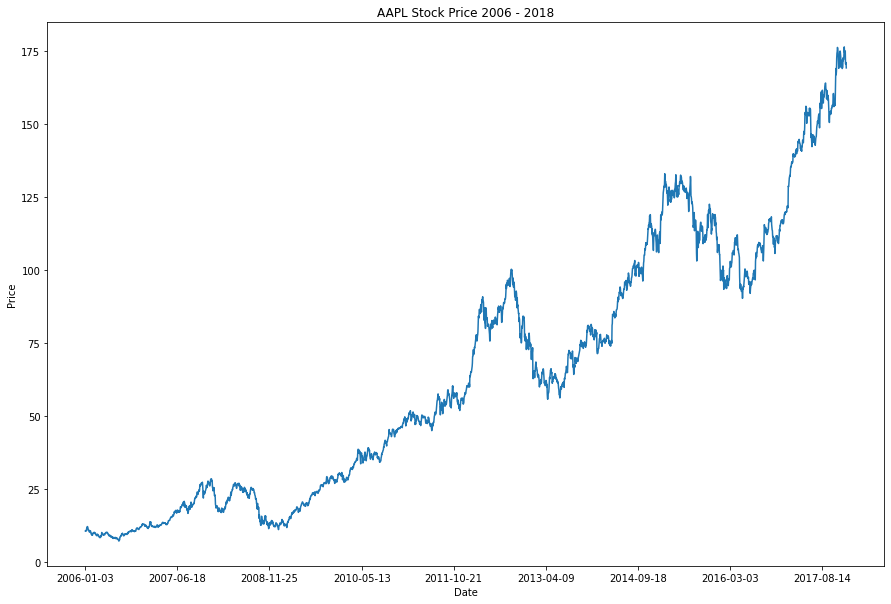

<Figure size 1080x648 with 0 Axes>

In [355]:

price_date = []
close_price = []

min_range = 0
max_range = 3090

with open('AAPL_data.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    count = 0
    for row in reader:
        if count >= min_range and count < max_range:
            price_date.append(row[0])
            close_price.append(float(row[4]))
        else:
            break
        count += 1
print(len(close_price))
price_date = np.array(price_date)
close_price = np.array(close_price)




plt.plot(price_date, close_price, marker='', linestyle='-')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.title('AAPL Stock Price 2006 - 2018')
plt.xlabel('Date')
plt.ylabel('Price')
plt.figure(figsize = (15,9))
plt.show()



#nomalizing the data
max_price = np.max(close_price)
close_price /= max_price

### Split data into training set and test set

In [356]:

#from https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
def split_data(stock_data, window_len, test_fraction=0.2):
    
    sequence = []
    for s in range(len(stock_data) - window_len):
        single_seq = stock_data[s:s+window_len]
        sequence.append(single_seq)
        
    sequence = np.array(sequence)
    
    test_size = int(len(stock_data) * test_fraction)
    train_size = len(stock_data) - test_size
    
    train_sample = sequence[:train_size, :-1]  #the element before the last value in each sequence
    train_sample = np.expand_dims(train_sample, axis=2)
    
    train_label = sequence[:train_size, -1]    #the last element will be the label for that sequence
    train_label = np.expand_dims(train_label, axis=1)
    
    test_sample = sequence[train_size:,:-1]
    test_sample = np.expand_dims(test_sample, axis=2)
    
    test_label = sequence[train_size:, -1]
    test_label = np.expand_dims(test_label, axis=1)
    
    return train_sample, train_label, test_sample, test_label

window_len = 20
train_sample, train_label, test_sample, test_label = split_data(close_price, window_len, test_fraction=0.2)

print(train_sample.shape)
print(train_label.shape)
print(test_sample.shape)
print(test_label.shape)
    

(2416, 19, 1)
(2416, 1)
(583, 19, 1)
(583, 1)


### Define model for neural network training

In [357]:
input_dim = 1
hidden_dim = 64
n_layers = 3
output_dim = 1
num_epochs = 100


#from https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, n_layers=n_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_sample_tensor = torch.from_numpy(train_sample).type(torch.Tensor)
train_label_tensor = torch.from_numpy(train_label).type(torch.Tensor)
test_sample_tensor = torch.from_numpy(test_sample).type(torch.Tensor)
test_label_tensor = torch.from_numpy(test_label).type(torch.Tensor)

### Train the model

In [358]:
loss_arr = []
predict_label = []
for i in range(num_epochs):
    predict_label = model(train_sample_tensor)
    loss = criterion(predict_label, train_label_tensor)
    loss_arr.append(loss.item())
    print("epoch: {}, loss: {}".format(i, loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 0, loss: 0.08397240191698074
epoch: 1, loss: 0.04010952636599541
epoch: 2, loss: 0.038410887122154236
epoch: 3, loss: 0.037440426647663116
epoch: 4, loss: 0.03582717478275299
epoch: 5, loss: 0.03152495622634888
epoch: 6, loss: 0.017985591664910316
epoch: 7, loss: 0.010369841009378433
epoch: 8, loss: 0.07145711034536362
epoch: 9, loss: 0.04975871741771698
epoch: 10, loss: 0.021739447489380836
epoch: 11, loss: 0.00995311327278614
epoch: 12, loss: 0.032795168459415436
epoch: 13, loss: 0.019483614712953568
epoch: 14, loss: 0.013532182201743126
epoch: 15, loss: 0.017399923875927925
epoch: 16, loss: 0.019175907596945763
epoch: 17, loss: 0.01578817330300808
epoch: 18, loss: 0.00842050090432167
epoch: 19, loss: 0.0033168760128319263
epoch: 20, loss: 0.007012052461504936
epoch: 21, loss: 0.009457000531256199
epoch: 22, loss: 0.0058870636858046055
epoch: 23, loss: 0.005693310406059027
epoch: 24, loss: 0.007351692765951157
epoch: 25, loss: 0.006517788395285606
epoch: 26, loss: 0.0042810039

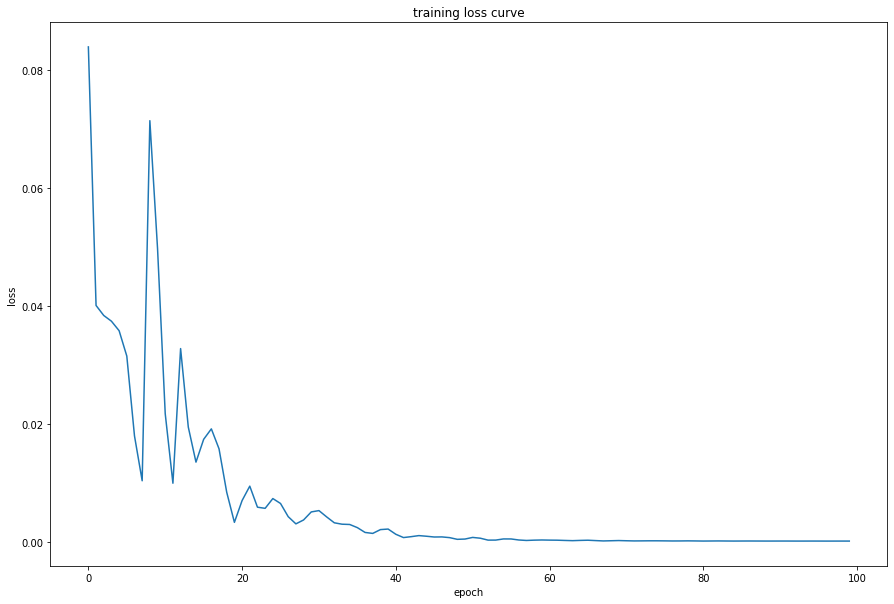

In [359]:
epoch_arr = np.linspace(0, num_epochs-1, num_epochs)
plt.plot(epoch_arr, loss_arr)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('training loss curve')
plt.show()


### Test the model with test set

In [360]:
with torch.no_grad():
    test_predict_label = model(test_sample_tensor)
    

test_predict_label = np.squeeze(test_predict_label.detach().numpy())
test_label_arr = np.squeeze(test_label_tensor.detach().numpy())

train_label_arr = np.squeeze(train_label_tensor.detach().numpy())
train_predict_label = np.squeeze(predict_label.detach().numpy())




#test with baseline
test_sample_arr = test_sample_tensor.detach().numpy()
test_predict_baseline = np.random.random(len(test_sample_arr))


### Show performance metrics

In [361]:
train_mse = np.average(np.square(train_predict_label*max_price - train_label_arr*max_price))
test_mse = np.average(np.square(test_predict_label*max_price - test_label_arr*max_price))

train_mae = np.average(np.abs(train_predict_label*max_price - train_label_arr*max_price))
test_mae = np.average(np.abs(test_predict_label*max_price - test_label_arr*max_price))




baseline_mse = np.average(np.square(test_predict_baseline*max_price - test_label_arr*max_price))
baseline_mae = np.average(np.abs(test_predict_baseline*max_price - test_label_arr*max_price))

metric_table = PrettyTable(["Metric Name","Training", "Testing", "Baseline"])

metric_table.add_row(["Mean Squared Error", train_mse, test_mse, baseline_mse])
metric_table.add_row(["Root Mean Squared Error", np.sqrt(train_mse), np.sqrt(test_mse), np.sqrt(baseline_mse)])
metric_table.add_row(["Mean Absolute Error", train_mae, test_mae, baseline_mae])


print(metric_table)

+-------------------------+-----------+-----------+-------------------+
|       Metric Name       |  Training |  Testing  |      Baseline     |
+-------------------------+-----------+-----------+-------------------+
|    Mean Squared Error   | 4.2875714 | 41.948612 | 4682.141071512925 |
| Root Mean Squared Error |  2.070645 | 6.4767747 | 68.42617241606405 |
|   Mean Absolute Error   |  1.420123 | 4.7818613 | 55.32102676752184 |
+-------------------------+-----------+-----------+-------------------+


### Overlay the prediction part on all the price data

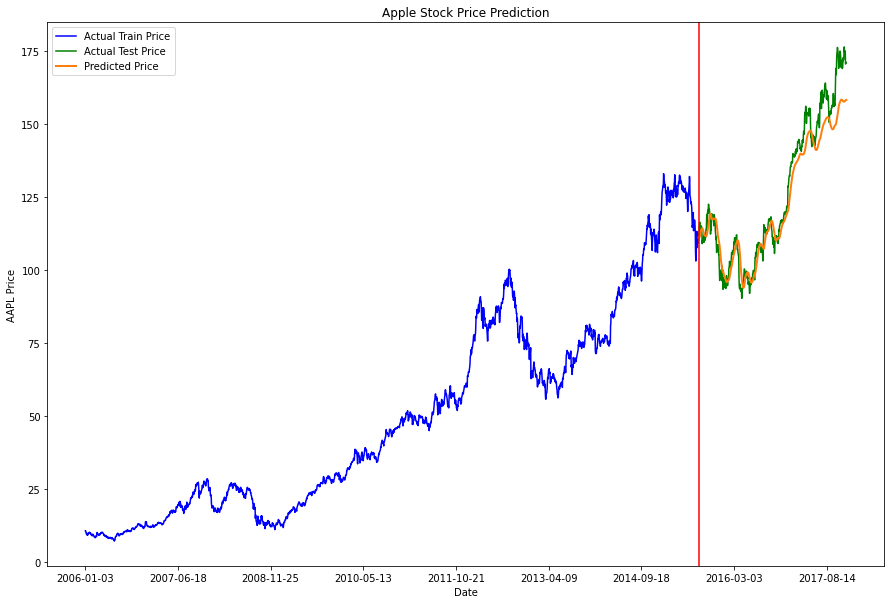

In [362]:


total_label = np.concatenate((np.squeeze(train_label), test_label_arr))
total_index_arr = np.linspace(0, len(total_label)-1, len(total_label))

predict_index_arr = np.linspace(train_label.shape[0]+1, train_label.shape[0]+test_label.shape[0], test_label.shape[0], dtype=np.int32)


total_label_price = total_label*max_price
plt.plot(price_date[:train_label.shape[0]+1], total_label_price[:train_label.shape[0]+1], label="Actual Train Price", color="b")
plt.plot(price_date[train_label.shape[0]+1:-window_len], total_label_price[train_label.shape[0]+1:], label="Actual Test Price", color="g")
plt.plot(price_date[predict_index_arr], test_predict_label*max_price, label="Predicted Price", color="tab:orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("AAPL Price")
plt.title("Apple Stock Price Prediction")
plt.legend()
plt.axvline(x=train_label.shape[0]+1, color='r')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.show()

### Use the trained model to predict 2018-2021 Apple stock price (beyond test data)

This part fails, no included in the report. It seems like more effort will need to make for LSTM to predict data beyond the test data

In [363]:
prediction_start_date = dt.datetime.strptime(price_date[-1],"%Y-%m-%d").date()

prediction_end_date = dt.date(2021, 1, 1)

print(prediction_start_date)
print(prediction_end_date)


days_diff = (prediction_end_date - prediction_start_date).days
print(days_diff)

starting_data = test_sample_tensor[-1]
starting_data = torch.unsqueeze(starting_data, 0)
# print(starting_data)


# print(torch.tensor([[[1.1]]]).shape)
# starting_data = torch.cat((starting_data[:,1:,:], torch.tensor([[[1.1]]])), 1)
# print(starting_data)

predict_further_arr = []
with torch.no_grad():
    for d in range(days_diff):
        predict_further_label = model(starting_data)     
        starting_data = torch.cat((starting_data[:,1:,:], torch.unsqueeze(predict_further_label, 0)),1)
        
        predict_further_arr.append(predict_further_label.item())
        
    
predict_further_arr = np.array(predict_further_arr)

print(predict_further_arr)


2017-12-29
2021-01-01
1099
[0.8970871  0.89586329 0.89407611 ... 0.6820001  0.68199998 0.68199998]


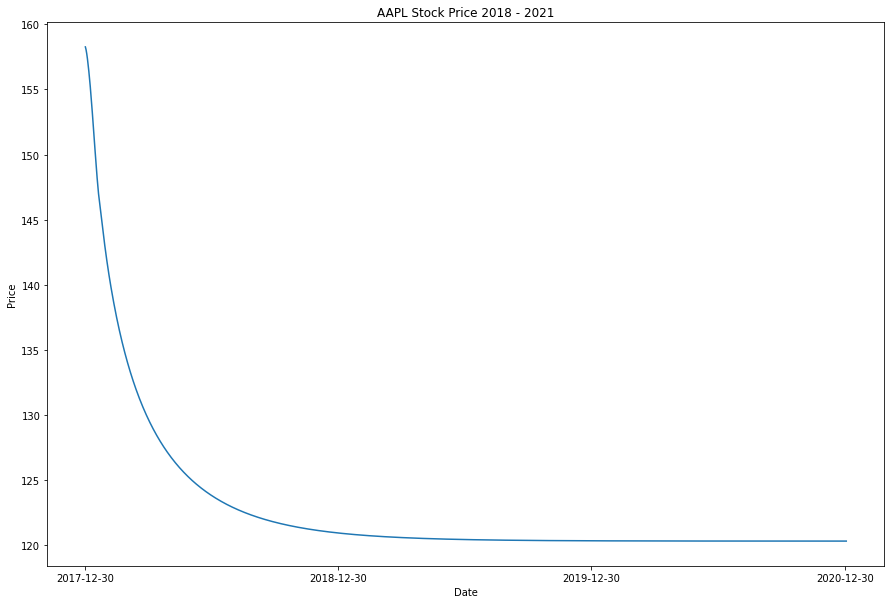

In [364]:
further_date_arr = []
curr_date = prediction_start_date
for fd in range(days_diff):
    curr_date = curr_date + dt.timedelta(days=1)
    curr_date_str = dt.datetime.strftime(curr_date, format='%Y-%m-%d')
    further_date_arr.append(curr_date_str)
    
    

plt.plot(further_date_arr, predict_further_arr*max_price, marker='', linestyle='-')
frame1 = plt.gca()
frame1.axes.xaxis.set_major_locator(YearLocator())
plt.title('AAPL Stock Price 2018 - 2021')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()